# RetroSynth (RS)
## Description
RetroSynth is a python tool which identfies enzyme/reaction pairs, using integer linear programming that need to be inserted into a select microbial organisms to produce a target chemical compound. 

In the process of bioengineering a microbial organism, identifying reactions and enzymes to genetically insert for optimal production of a chemical compound is extremely difficult due to the vast number of enzymes/reactions pairs in numerous organisms that maybe available.  

By assembling a database of genome-wide metabolic networks for a plethora of microbial organisms and framing this information into an integer linear program, we can identify the minimal number of enzyme/reaction pairs that are necessary to be transformed into an organism for synthesis of a compound.  Identifying the minimal number of enzyme/reaction pairs steps is beneficial for cost and success as less genetic manipulation would be required.  Furthermore, RS can predict theoretical production yields of a compound by simulating metabolism using flux balance analysis (FBA) of the select microbial organism.

The overaching goal of RS is to streamline an arduous and complex step of bioengineering a microbial organism, which will enable scientists to inexpensively expedite the production of important chemical compounds.

## RS Workflow
1. Install necessary libraries for RS
2. Construction of Metabolic Database
3. Target Compounds
4. Generating Stoichiometric Matrix for Reactions and Compounds in the Metabolic Database
5. Obtain pathway

## Installation of python and other libraries for RS
1. To run RS the install the linear programming software GLPK and the corresponding partner package GMP

    GNU/GLPK 	 Download from the website http://ftp.gnu.org/gnu/glpk/ (glpk-4.64.tar.gz for   mac)
2. To get figures install graphviz
   
    GraphViz     Download from the website http://graphviz.org/ or using MacPorts or brew

3. Install following python libraries

    glpk==0.3 or pulp (glpk is faster however if on linux or mac with versions glpk-4.4 or higher glpk will not work so pulp should be used instead. Pulp is the default.  
    
    pulp==1.6.8
   
    cobra==0.6.2
    
    pygraphviz==1.3.1
    
    beautifulsoup==4-4.4.1-3
    
    python-libsbml-experimental==5.10.0

### Import Libraries
Imports necessary python libraries for running RS

In [15]:
#Python Libraries
from multiprocessing import Process, Queue
import urllib2
import argparse
import cPickle
import sys
import os
import re
import glob

#Adds necessary Paths to PATH enviornment to use graphviz
#likely only necessary if graphviz was downloaded with macports 
#or brew and using canopy
paths = os.environ['PATH'].split(':')
if '/opt/local/sbin' not in paths:
    os.environ['PATH'] = os.environ['PATH']+':/opt/local/sbin'
if '/opt/local/bin' not in paths:
    os.environ['PATH'] = os.environ['PATH']+':/opt/local/bin'

# If using a proxy, proxy address will need to be added in between quotes '' to 
# work in this jupyter notebook
proxy_support = urllib2.ProxyHandler({
'http': 'http://wwwproxy.sandia.gov:80',
'https': 'https://wwwproxy.sandia.gov:80'
})
opener = urllib2.build_opener(proxy_support)
urllib2.install_opener(opener)

#Parser Libraries
from Parser import read_startcompounds as rtsc
from Parser import read_targets as rt
from Parser import generate_output as go
from Parser import structure_similarity as ss

#Visualization Libraries
from Visualization import SP_Graph_dot as spgd
from Visualization import reaction_files as rf

#Shortest Path Libraries
from ShortestPath import extractinfo as ei
from ShortestPath import constraints as co
from ShortestPath import integerprogram_glpk as ip_glpk
from ShortestPath import integerprogram_pulp as ip_pulp
from ShortestPath import search_sp_metclusters as smc

#Database Libraries
import sqlite3
from Database import initialize_database as init_db
from Database import build_kbase_db as bkdb
from Database import build_KEGG_db as bkeggdb
from Database import build_metacyc_db as bmcdb
from Database import build_ATLAS_db as batlasdb
from Database import build_MINE_db as bminedb
from Database import build_SPRESI_db as bspresidb
from Database import remove_duplicate_cpds as rdc
from Database import query as Q

#Flux balance analysis Libraries
from FBA import build_model as bm
from FBA import optimize_target as ot
from FBA import compare_results as cr
from FBA import retrieve_producable_mets as rpm
from FBA import compareKO_results as crko

PATH = os.path.dirname(os.path.abspath("__file__"))



### Specifiy User Options
Set options necessary for running RS (most important box for user to review)

In [16]:
#file of target molecules. Required!
target_file = '/Users/lwhitmo/Retrosynthesis/CompoundLists/test.txt'

#User can specify specific directory for results to be stored 
#(default will be path where RS is located)
output_path = '/Users/lwhitmo/Desktop'         

#python package to use to connect to glpk solver software (can use GLPK or PULP (default))
_solver = 'PULP'

#Time limit to get a solution ( only works with PULP)
_solver_time_limit = 'None'

#Determines whether new database is necessary. If user already has developed a database and wants 
#to use it then this should be set to False.
create_new_database = False

#Name of database. Required!
database = '/Users/lwhitmo/DBinchi_kbase_mc_revers_kegg_MINE_ATLAS.db'

#Determines whether to generate new constraint file.  If False will use a constraint file already present
create_new_constraints = False

#Constraint file. Required! if create_new_constraints = True or False
constraints_file = '/Users/lwhitmo/DBinchi_kbase_mc_revers_kegg_MINE_ATLAS.constraints'

#Whether inchi values will be used as compound identifiers in database
inchidb = True

#Type of database to create (change to True)
kbase = False

metacyc = False

kegg = False

mine = False

atlas = False

SPRESI = False

#Directory of metabolic networks. Required if create_new_database = True 
kbase_dir = './tests/data'

#XML file of metacyc reactions. Required if metacyc = True
metacyc_xml_file = './tests/data7/metabolic-reactions.xml'

#Translation file of metacyc compound IDs to kbase. Required if metacyc = True
translation_file = './tests/data7/MetaCyc.aliases'

#Folder where spresi rdf files are stored. Required if SPRESI = True
spresi_dir = ''

#Folder where MINE files (.msp) are stored. Required if mine = True
mine_dir = ''

#Folder where ATLAS files (.csv) are stored. Required if atlas = True
atlas_dir = ''

#Type of reactions being added to database. Required if create_new_database = True
kbase_reaction_type = 'bio'

#Type of reactions being added to database. Required if create_new_database = True
metacyc_reaction_type = 'bio'

#Type of reactions being added to database. Required if create_new_database = True
kegg_reaction_type = 'bio'

#Type of species (bacteria, algae) to add reactions to the database
kegg_organism_type = 'bacteria'

#Number of organisms to add to the database from the kegg database
kegg_number_organisms = '1'

#Number of pathways from each organism to add from the organism to the database
#from the kegg database
kegg_number_pathways = '1'

#Type of reactions being added to database. Required if create_new_database = True
mine_reaction_type = 'bio'

#Type of reactions being added to database. Required if create_new_database = True
atlas_reaction_type = 'bio'

#Type of reactions being added to database from spresi. Required if spresi_addition = True
spresi_reaction_type = 'chem'

#Sets whether to run flux balance analysis
flux_balance_analysis = True

#File specifying media components for running flux balance analysis
media_for_FBA = ''

#Sets whether to run knockout analysis when running flux balance analysis
#(this can be time consuming)
knockouts = False

#Limits numer of reactions in a path
limit_reactions = 10

#Limits number of times cycle can be eliminated (not totally functional yet)
limit_cycles = 'None' 

#Defines which type of reactions (bio, chem, or all (default)) 
#to be evaluated in identifying shortest paths
evalrxns = 'all'

#List of starting compounds (cannot be used with flux_balance_analysis)
start_compounds = ''

#Find multiple solutions
multiple_solutions = 'True'

#Find next shortest path
k_number_of_paths = 0

#Find pathways with out cycles
cycles = 'True'

#How many processors to use when finding shortest paths
processors = 1

#Sets whether to generate figures
figures = True

#Set whether to use chemical images or round nodes in output figures (default True)
_images = True

#set tanimoto threshold score
tanimoto_threshold = 1.0


### Construction of Metabolic Database

In [17]:
##Connect to or create metabolic database
def get_compartment(DB):
    compartmentID_array = DB.get_compartment('cytosol')
    if compartmentID_array is None:
        compartmentID = 'c0'
    else:
        if compartmentID_array[0] == '':
            compartmentID = 'c0'
        else:
            compartmentID = compartmentID_array[0]
    return (compartmentID)

if not database:
    raise ValueError('need a file for database, see Specify User Options cell')

if create_new_database:
    init_db.Createdb(database, inchidb)
    DB = Q.Connector(database)
    if kbase:
        if not kbase_dir:
            raise ValueError('need a folder path for dump_directory, see Specify User Options cell')     
        bkdb.BuildKbase(kbase_dir, PATH+'/Database/KbasetoKEGGCPD.txt',
                        PATH+'/Database/KbasetoKEGGRXN.txt',
                        inchidb, database, kbase_reaction_type)
    if metacyc:
        bmcdb.Translate(database, DB, metacyc_xml_file, translation_file,
                            inchidb, metacyc_reaction_type)
    if kegg and (kbase or metacyc):
        '''
        Add kegg database
        '''
        BKD = bkeggdb.CompileKEGGIntoDB(database, kegg_organism_type,
                                        inchidb, processors, kegg_number_organisms,
                                        kegg_number_pathways, kegg_reaction_type,
                                        add=True)
        DB = BKD.DB
    elif kegg and not kbase and not metacyc:
        '''
        Add only kbase database
        '''
        print ('STATUS: Only KEGG')
        BKD = bkeggdb.CompileKEGGIntoDB(database, kegg_organism_type,
                                        inchidb, processors, kegg_number_organisms, 
                                        kegg_number_pathways, kegg_reaction_type,
                                        add=False)
        DB = BKD.DB

    if SPRESI:
        if not spresi_dir:
            raise ValueError('need folder path for spresi folder, see Specify User Options cell')
        compartmentID = get_compartment(DB)
        bspresidb.RDF_Reader(spresi_dir, database, spresi_reaction_type,
                                  compartmentID, processors)
        DB = Q.Connector(database)

    if mine:
        bminedb.BuildMINEdb(mine_dir, database,
                            inchidb, mine_reaction_type)

    if atlas:
        batlasdb.build_atlas(atlas_dir, database, inchidb,
                             processors, atlas_reaction_type)

    rdc.OverlappingCpdIDs(database)
    DB = Q.Connector(database)

else:
    DB = Q.Connector(database)
    if kbase:
        bkdb.BuildKbase(kbase_dir, PATH+'/Database/KbasetoKEGGCPD.txt',
                        PATH+'/Database/KbasetoKEGGRXN.txt',
                        inchidb, database, kbase_reaction_type)
    if metacyc:
        bmcdb.Translate(database, DB, metacyc_xml_file, translation_file,
                            inchidb, metacyc_reaction_type)
    if kegg and (kbase or metacyc):
        '''
        Add kegg daatabase
        '''
        BKD = bkeggdb.CompileKEGGIntoDB(database, kegg_organism_type,
                                        inchidb, processors, kegg_number_organisms,
                                        kegg_number_pathways, kegg_reaction_type,
                                        add=True)
        DB = BKD.DB

    if SPRESI:
        if not spresi_dir:
            raise ValueError('need folder path for spresi folder, see Specify User Options cell')
        compartmentID = get_compartment(DB)
        bspresidb.RDF_Reader(spresi_dir, database, spresi_reaction_type,
                                  compartmentID, processors)
        DB = Q.Connector(database)
    if mine:
        bminedb.BuildMINEdb(mine_dir, database,
                            inchidb, mine_reaction_type)

    if atlas:
        batlasdb.build_atlas(atlas_dir, database, inchidb,
                             processors, atlas_reaction_type) 

    if inchidb and (kbase or metacyc or kegg or SPRESI or mine or atlas):
        '''only run to remove overlapping ids if a database was added''' 
        rdc.OverlappingCpdIDs(database)
    DB = Q.Connector(database)

##Pull out reactions to be searched through to identify shortest path
allcpds = DB.get_all_compounds()
if evalrxns == 'all':
    allrxns = DB.get_all_reactions()
elif evalrxns == 'bio':
    allrxns = DB.get_reactions_based_on_type('bio')
elif evalrxns == 'chem': 
    allrxns = DB.get_reactions_based_on_type('chem')


### Read in target compounds

In [18]:
if not target_file:
    raise ValueError('need a file for target_file, see Specify User Options cell')
R = rt.Readfile(target_file, DB, inchidb)
if len(R.targets) == 0:
    raise ValueError('ERROR: No targets, try different compounds')
output = go.Output(DB, output_path, flux_balance_analysis, knockouts)
if inchidb:
    print ('STATUS: {} tanimoto threshold being used'.format(float(tanimoto_threshold)))
    SIM = ss.TanimotoStructureSimilarity(R.targets, DB.get_all_compounds(),
                                         DB.get_compartment('cytosol')[0],
                                         DB.get_compartment('extracellular')[0],
                                         tanimoto_threshold)
    targets = SIM.finaltargets
    ignore_reactions = R.ignorerxns
else:
    targets = R.targets
    ignore_reactions = R.ignorerxns


STATUS: 1.0 tanimoto threshold being used


  0%|          | 0/610819 [00:00<?, ?it/s]

STATUS: getting fingerprints for target compounds
STATUS: getting fingerprints for database compounds


100%|██████████| 610819/610819 [18:10<00:00, 560.06it/s]


STATUS: The following compound InChI=1S/C10H18O/c1-9(2)8-4-6-10(3,11-9)7-5-8/h8H,4-7H2,1-3H3/t8?,10- have 100 percent similarity with the original target InChI=1S/C10H18O/c1-9(2)8-4-6-10(3,11-9)7-5-8/h8H,4-7H2,1-3H3 therefore adding them to to targets
STATUS: The following compound InChI=1S/C10H16/c1-7(2)10-5-4-8(3)9(10)6-10/h7,9H,3-6H2,1-2H3/t9-,10-/m1/s1 have 100 percent similarity with the original target InChI=1S/C10H16/c1-7(2)10-5-4-8(3)9(10)6-10/h7,9H,3-6H2,1-2H3 therefore adding them to to targets


### Construct Database constraints

In [19]:
if not constraints_file:
    raise ValueError('need a specified file for constraints_file, see Specify User Options cell')
if create_new_constraints:
    LP = co.ConstructInitialLP(allrxns, allcpds, DB,
                               ignore_reactions, True,
                               reverse_constraints=False,
                               specified_pysolver=_solver)
    with open(constraints_file, 'wb') as fout1:
        cPickle.dump(LP.A, fout1)
        cPickle.dump(LP.allcpds, fout1)

else:
    with open(constraints_file, 'rb') as fin1:
        A = cPickle.load(fin1)
        allcompounds4matrix = cPickle.load(fin1)
    LP = co.ConstructInitialLP(allrxns, allcompounds4matrix, DB,
                               ignore_reactions, A,
                               reverse_constraints=False,
                               specified_pysolver=_solver)


  0%|          | 173/854195 [00:00<08:13, 1729.46it/s]

STATUS: Generating reaction constraints ...


  0%|          | 228/615234 [00:00<05:22, 1909.23it/s]

STATUS: Generating compound constraints from preloaded file (pulp) ...


100%|██████████| 615234/615234 [05:03<00:00, 2026.34it/s]


### Set up integer program and active metabolism

In [20]:
#Develops IP
DB = Q.Connector(database)
if LP.PYSOLVER is 'GLPK':
    IP = ip_glpk.IntergerProgram(DB, limit_reactions, limit_cycles,
                                 k_number_of_paths, cycles)
elif LP.PYSOLVER is 'PULP':
    IP = ip_pulp.IntergerProgram(DB, limit_reactions, limit_cycles,
                                 k_number_of_paths, cycles, _solver_time_limit)

#Determines active metabolism if flux_balance_analysis is True
active_metabolism = {}
if flux_balance_analysis:
    organisms = set()
    output_queue = Queue()
    for target_info in targets:
        organisms.add(target_info[2])
    organisms = list(organisms)
    args_organisms = [organisms[i:i+processors] for i in range(0, len(organisms), processors)]
    for orgs in args_organisms:
        processes = []
        for org in orgs:
            incpds = DB.get_compounds_in_model(org)
            inrxns = DB.get_reactions_in_model(org)
            processes.append(Process(target = rpm.RetrieveActiveRxnsCompounds,
                                     args=(org, incpds, inrxns, DB, output_queue,
                                           media_for_FBA)))
        for p in processes:
            p.start()
        for p in processes:
            ac = output_queue.get()
            active_metabolism.update(ac)
    output.output_activemetabolism(active_metabolism)

STATUS: Getting organism compounds ... 
STATUS: Getting organism reactions ... 
STATUS: Determine what compounds in network are active (can be produced)


100%|██████████| 1275/1275 [02:40<00:00,  7.95it/s]


### Identify shortest paths

In [22]:
#Function determines what was inputed for a specific target 
def _specific_target(target_id):
    if target_id in ['', 'NA', 'N/A']:
        return False
    else:
        return True

#Function finds shortest path    
def retrieve_shortestpath(target_info, IP, LP, database, output, active_metabolism):
    DB = Q.Connector(database)
    print (target_info)
    if not _specific_target(target_info[2]) and not start_compounds:
        print ('WARNING: No organism given therefore software will run all organisms in database {} compound'.format(target_info[0]))
        ''' takes about 5 hours '''
        smc.SearchMetabolicClusters(target_info[0], LP, IP, output, DB)
    else:
        if start_compounds:
           incpds = rtsc.readfile_startcompounds(start_compounds)
           inrxns = []
        else:
            incpds = DB.get_compounds_in_model(target_info[2])
            inrxns = DB.get_reactions_in_model(target_info[2])

        if flux_balance_analysis:
            incpds_active = active_metabolism[target_info[2]][0]
            inrxns_active = active_metabolism[target_info[2]][1]
        else:
            incpds_active = incpds
            inrxns_active = inrxns

        if target_info[0] in incpds_active: #Check if compound exists in organism
            output.output_compound_natively_present_in_target_organism(target_info)
        else:
            optimal_pathways = IP.run_glpk(LP, incpds_active, inrxns, target_info[0],
                                           multiplesolutions=multiple_solutions)
            if optimal_pathways:
                uniq_externalrxns = []
                for path in optimal_pathways:
                    path_org = []
                    for rxn in path:
                        rxn = re.sub('_F$', '', rxn)
                        rxn = re.sub('_R$', '', rxn)
                        path_org.append(rxn)
                    uniq_externalrxns.append(list(set(path_org) - set(inrxns)))

                ex_info = ei.Extract_Information(optimal_pathways, incpds_active, DB)
                output.output_shortest_paths(target_info, ex_info.temp_rxns)
                if flux_balance_analysis:
                    opt_fba = run_flux_balance_analysis(target_info, ex_info, incpds, 
                                                        incpds_active, inrxns_active,
                                                        media_for_FBA, knockouts,
                                                        output, figures, DB, LP)
                    if figures:
                        G = spgd.GraphDot(DB, output_path, incpds_active, inrxns,
                                          opt_fba.fbasol.x_dict)
                        G.sc_graph(target_info[0], target_info[2], ex_info.temp_rxns, _images)                     
                        R = rf.ReactionFiles(output_path, DB, ex_info.temp_rxns,
                                         target_info[0], target_info[2], incpds_active)
                        output.output_extra(target_info[0], R.ordered_paths, ex_info.temp_rxns, incpds_active)

                elif figures and not flux_balance_analysis:
                    G = spgd.GraphDot(DB, output_path, incpds, inrxns)
                    G.sc_graph(target_info[0], target_info[2], ex_info.temp_rxns, _images)
                    R = rf.ReactionFiles(output_path, DB, ex_info.temp_rxns,
                                     target_info[0], target_info[2], incpds)                    
                    output.output_extra(target_info[0], R.ordered_paths, ex_info.temp_rxns, incpds_active)

            else:
                output.output_shortest_paths(target_info, [])
                if flux_balance_analysis:
                    print('WARNING: No optimal path for %s in species %s therefore no \
                          flux balance will be performed' % (target_info[0], target_info[2]))
    DB.conn.close()

#Function runs flux balance analysis

def run_flux_balance_analysis(target_info, ex_info, incpds_original,
                              incpds_active, inrxns, media, ko,
                              output, figures, DB, LP):
    '''
    Run flux balance analysis on target organism with added reactions
    necessary to produce target compound
    '''
    fba = bm.BuildModel(target_info[2], incpds_original, inrxns, DB, media)
    opt_fba = ot.OptimizeTarget(target_info[0], target_info[2],
                                fba.model, ex_info.temp_rxns,
                                ex_info.temp_exmets,
                                fba.compounds_dict, incpds_active,
                                inrxns, DB, ko)
    comparisonresults = cr.Compare(target_info[0], fba.solution,
                                   opt_fba.fbasol, ex_info.temp_rxns, DB)
    output.output_FBA(target_info, fba.solution, opt_fba, comparisonresults,
                      ex_info.temp_rxns)
    output.output_theoretical_yield(target_info[0], target_info[2],
                                    opt_fba.fbasol,
                                    opt_fba.compounds_dict)
    if ko:
        output.output_essential_reactions(target_info[0], target_info[2],
                                          opt_fba.essentialrxns)
        comparisonKOresults = crko.CompareKO(target_info[0], opt_fba.fbasol,
                                             opt_fba.KOsolutions,
                                             ex_info.temp_rxns, DB)
        output.output_FBA_KOs(target_info, comparisonKOresults,
                              ex_info.temp_rxns)
    return(opt_fba)

#Actually runs functions to identify shortest paths
args_rcp_chunks = [targets[i:i+processors] for i in range(0, len(targets), processors)]
for chunks in args_rcp_chunks:
    processes = [Process(target=retrieve_shortestpath,
                         args=(chunk, IP, LP, database, output, active_metabolism)) for chunk in chunks]
    for p in processes:
        p.start()
    for p in processes:
        p.join()
'''Remove all temporary images'''
if _images:
    for filename in glob.glob(PATH+"/Visualization/compound*"):
        os.remove(filename) 


['InChI=1S/C10H16/c1-7(2)10-5-4-8(3)9(10)6-10/h7,9H,3-6H2,1-2H3_c0', '', 'kb_g_0_fbamdl176', '']
STATUS: Setting compound constraints ...
STATUS: Generating objective function coefficients ...
STATUS: Setting objective function ...
STATUS: Solving problem ...
STATUS: Checking for cycles in the identified pathways
STATUS: No cycles were found
STATUS: Checking for multiple optimal solutions ... 
STATUS: Setting objective function ...
STATUS: Solving problem ...
STATUS: Checking for cycles in the identified pathways
STATUS: No cycles were found

SHORTEST PATH FOR InChI=1S/C10H16/c1-7(2)10-5-4-8(3)9(10)6-10/h7,9H,3-6H2,1-2H3_c0 sabinene in target organism Escherichia_coli_K12.xml
Solution 1
rxn24046_c0	RXN-5103	forward	4.2.3.-	G-10243 or G-9788 or AG11 or AT3G25820
	InChI=1S/C10H20O7P2/c1-9(2)5-4-6-10(3)7-8-16-19(14,15)17-18(11,12)13/h5,7H,4,6,8H2,1-3H3,(H,14,15)(H2,11,12,13)/p-3/b10-7+_c0	geranyl diphosphate reactants
	InChI=1S/C10H16/c1-7(2)10-5-4-8(3)9(10)6-10/h7,9H,3-6H2,1-2H3_c0	sabin

### Figures 
The final code in this notebook shows figures generated within the jupyter notebook.  
Key for figures:

Gray compounds = Native compounds to target organism

Blue compounds = Non native compounds to the target organism

Red compound = Target compound

FINISHED GETTING PATHWAYS OUTPUT FIGURES TO JUYPTER NOTEBOOK
/Users/lwhitmo/Desktop/reaction_figures/colorbarforreactionflux.png


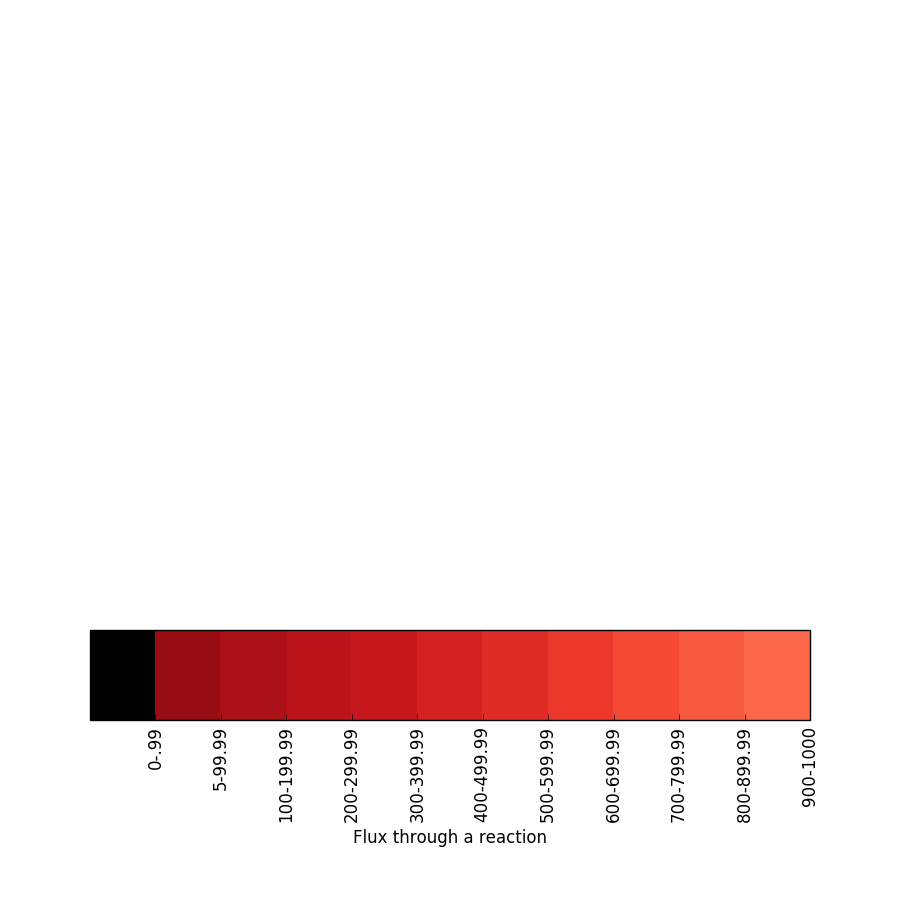

/Users/lwhitmo/Desktop/reaction_figures/SC_graph_(+)_sabinene_Escherichia_coli_K12.xml.png


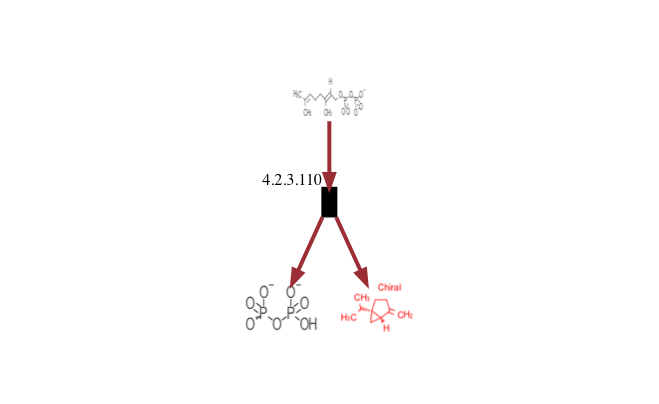

/Users/lwhitmo/Desktop/reaction_figures/SC_graph_1,8_cineole_Escherichia_coli_K12.xml.png


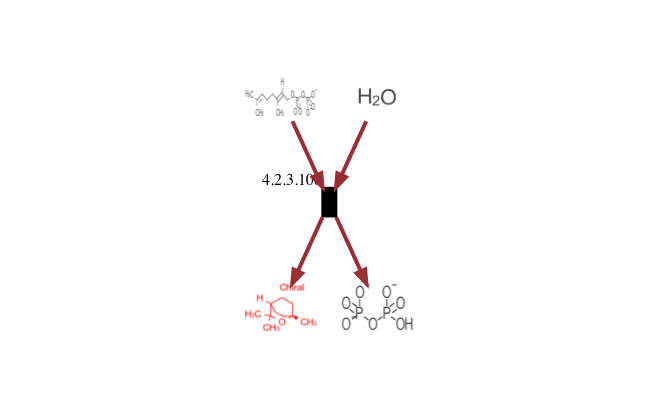

/Users/lwhitmo/Desktop/reaction_figures/SC_graph_sabinene_Escherichia_coli_K12.xml.png


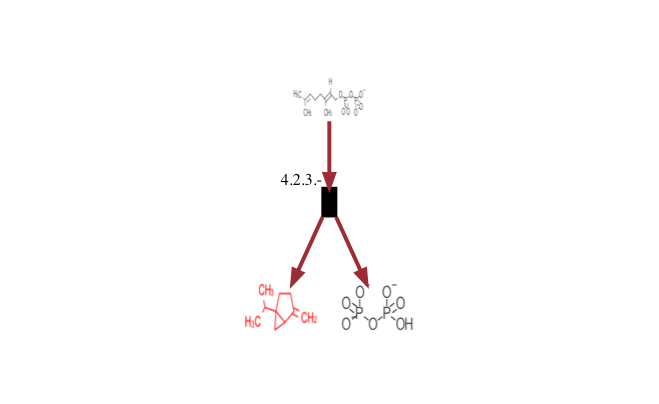

In [23]:
print ('FINISHED GETTING PATHWAYS OUTPUT FIGURES TO JUYPTER NOTEBOOK')
#Display figures in Juypter Notebook
import IPython.display as dp
import glob
files = glob.glob(os.path.join(output_path+'/reaction_figures', '*.png'))
for file_name in files:
    print (file_name)
    dp.display_png(dp.Image(filename=file_name, format='png'))

